In [282]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [283]:
#Fixes to try: 
#1. Get discrete dynamics jacobians with RK4. Matrix exponential is only exact for LTI systems. (done)
#2. Implement the second order correction (done)
#3. More conservative half space constraint
#4. Change the c at each knot point according to the maximum delta x deviation possible

#4. Current orbit is not exactly periodic (xend - xinitial). Set the reference trajectory to that orbit revd twice instead of concatenating two arrays (potential fix)

In [284]:
# ##############################################
# ##
# #scaling:
# #have Lagrange point as the origin
# #scale position so that the norm of the first position vector is 1
# #scale time so that the period of the orbit is 1
# ##############################################


# custom_position_scale_L1 = norm(halo_linear_L1_origin[1:3,1])

# custom_time_scale_L1 = h_L1_rk4*(N-1) 

# custom_velocity_scale_L1 = custom_position_scale_L1/custom_time_scale_L1

# custom_position_scale_L2 = norm(halo_linear_L2_origin[1:3,1])

# custom_time_scale_L2 = h_L2_rk4*(N-1) 

# custom_velocity_scale_L2 = custom_position_scale_L2/custom_time_scale_L2

# custom_units_L1 = [custom_position_scale_L1, custom_velocity_scale_L1, custom_time_scale_L1]

# custom_units_L2 = [custom_position_scale_L2, custom_velocity_scale_L2, custom_time_scale_L2]

# ##

In [285]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [286]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [287]:
# T_og = 2.361e6 #in seconds - orbital period of m1 and m2
# time_scale_og = T_og/(2*pi)

In [288]:
#parameters for Earth Moon System
μ = 1.215e-2
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 3.850e5 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2

#updated for time unit to be in days
T_ = 2.361e6/86400 #in days - orbital period of m1 and m2
time_scale = T_/(2*pi)

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.1556799130947355
 0.0
 0.0
 0.0
 0.0
 0.0

In [289]:
acceleration_scale

20354.29089708545

In [290]:
time_scale

4.349129868518112

In [291]:
V_

88523.45449302066

In [292]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [293]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [294]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [295]:
#this just scales the dynamics by L and V_

In [296]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [297]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [298]:
#this shifts the origin to L2 and scales by custom scales

In [299]:
# #inputs are in the custom scaled units

# function three_body_dynamics_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),6)

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics(x_original_unshift)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled

# end

In [300]:
# #inputs are in the custom scaled units

# function three_body_dynamics_wcontrol_scaled(x)

#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     u_original = zeros(eltype(x),3)
    
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
#     u_original = x[7:9]*custom_acceleration_scale
    
#     x_original = [q_original; v_original]

#     #get it back to original units and without the L2 shift  
#     x_original_unshift = x_original+ XL2

#     ẋ_original = zeros(eltype(x),9)

#     #x in regular units
#     x_reg = [x_original_unshift; u_original]

#     #calculate the original xdot (no scaling)

#     ẋ_original = three_body_prob_dynamics_wcontrol(x_reg)

#     #then scale the output
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale

#     u_scaled = ẋ_original[7:9]/custom_accel_scale

#     ẋ_scaled = [v_scaled; a_scaled; u_scaled]

#     return ẋ_scaled

# end

In [301]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [302]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [303]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [304]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [305]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [306]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [307]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [308]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [309]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [310]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [311]:
#gets the state and transition matrix for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [312]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [313]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [314]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [315]:
T_ 

27.32638888888889

In [316]:
time_scale 

4.349129868518112

In [317]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.4071472466192527

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#in CR3BP units
x0_L2 = richardson[:,1]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [318]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [319]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [320]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [321]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [322]:
#nonzero_cmplx_eigen_L2

In [323]:
#real(direction2_L2)

In [324]:
#real(direction3_L2)

In [325]:
#real(direction4_L2)

In [326]:
#real(direction5_L2)

In [327]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [328]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369490.75767211843 369665.9710674244; 0.0 2.1072953725303933 … -44953.87864401415 -45157.53537525589; … ; 15342.188285037404 15342.188246755026 … -2970.8002948868807 -1571.3827010134341; 0.0 -0.23903800908705172 … 2253.1489980700185 2425.087423840762], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.00000002495156 4.49033097804662e-13 … 1.738928494135653e-8 3.1495822485791465e-13; -1.953807178609287e-13 0.9999999903352349 … 0.0002750059218200475 2.911771885389355e-18; … ; -2.13138009835851e-9 -7.02876863614485e-5 … 0.999999982338562 4.2352132714362174e-14; 2.

In [329]:
stm_in 

6×6×231 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0

[:, :, 2] =
  1.0           5.59457e-14   8.57086e-10  …  4.33784e-9   3.92411e-14
 -2.43428e-14   1.0          -6.38439e-15     0.000137353  1.81193e-19
  8.57086e-10   1.16611e-14   1.0             1.42049e-18  0.000137353
  9.0632e-5     1.22194e-9    1.248e-5        6.31634e-5   8.57086e-10
 -5.31683e-10  -3.51055e-5   -1.39445e-10     1.0          5.27671e-15
  1.248e-5      2.54696e-10  -4.10033e-5   …  4.13677e-14  1.0

[:, :, 3] =
  1.0           4.49033e-13   3.43583e-9   …  1.73893e-8   3.14958e-13
 -1.95381e-13   1.0          -5.12426e-14     0.000275006  2.91177e-18
  3.43583e-9    9.35947e-14   1.0             2.28273e-17  0.000275006
  0.000181462   4.89844e-9    2.49873e-5      0.000126465  3.43583e-9
 -2.13138e-9   -7.02877e-5   -5.58998e-10     1.0     

In [330]:
#stm_in[:,:,210]

In [331]:
#a = LinRange(1,2,10)

In [332]:
#solution_in(a).u[2]

In [333]:
initial_norm = all_state_in[:,end] - all_state_in[:,1]

6-element Vector{Float64}:
 -61583.97507422161
 -45157.53537525589
 -10110.510441659993
   2028.1940531629507
 -16913.57098605084
   2425.087423840762

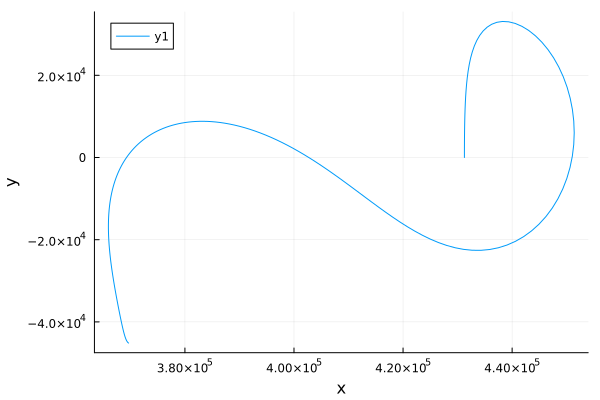

In [334]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [335]:
#fix with a single shooting differential corrector
function differential_corrector(x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        #println("this is stm s: ")
        #println(stm_s)


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]


        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        

        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6

            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [336]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

residual: [1643.9520665946734, -191.49882013184757]
residual: [2.50640377938576, 35.41406163738534]
residual: [-495.1172851568247, 60.68877908842731]
residual: [-24.37546876993494, 8.50685424720485]
residual: [-110.46814192446912, 9.54009309010716]
residual: [-13.136469711447523, 1.7580358490853736]
residual: [-14.472588166878632, 1.0122264537249142]
residual: [-1.505303267632691, 0.12529129664950409]
residual: [-0.11476903723509187, 0.007755367827106863]
residual: [-0.00012003677020844276, 1.8507296361931575e-5]
residual: [-8.464284497666003e-5, -3.1672155774008355e-6]
residual: 

[1.1112903456945178e-5, 4.156345805856892e-7]
residual: [0.00010115294184219924, 3.78624364506784e-6]
residual: [-0.00010840135247014187, -4.056172106837442e-6]
residual: [4.0602026942756594e-5, 1.5196958162793624e-6]
residual: [-4.491641912241997e-5, -1.6801875776502769e-6]
residual: [8.95029402409035e-5, 3.3480900212831964e-6]
residual: [2.5252954553504204e-5, 9.458764132468768e-7]
residual: [-1.5483155655303155e-5, -5.785185157914026e-7]
residual: [-8.026794659420528e-5, -3.0054982644975674e-6]
residual: [3.1055926559410706e-5, 1.1632407198312141e-6]
residual: [6.469879778732865e-5, 2.4212245489917717e-6]
residual: [-0.00011129223098197742, -4.1640472381567256e-6]
residual: 

[0.000108232138548067, 4.050314476144882e-6]
residual: [-7.1045221471022355e-6, -2.658524158489944e-7]
residual: [-0.00010687300666023267, -3.99845443227954e-6]
residual: [7.499424380247476e-5, 2.806545961882676e-6]
residual: [-5.227632212883458e-5, -1.9555055820348197e-6]
residual: [2.526325674966117e-5, 9.445346270878232e-7]
residual: [1.9801600011476456e-5, 7.422629668894696e-7]
residual: [-4.346841780775944e-6, -1.6330339089233627e-7]
residual: [-1.60204148731252e-5, -6.00318410863837e-7]
residual: [3.062028147907081e-5, 1.147433390467218e-6]
residual: [-2.8017325418676855e-5, -1.049653728806627e-6]
residual: [-4.2778209989353145e-5, -1.5997260237646634e-6]
residual: 

[4.148803703102518e-5, 1.5519584539873197e-6]
residual: [-4.8924413485962816e-5, -1.8307285484751985e-6]
residual: [0.00011379102347439839, 4.258246409763198e-6]
residual: [7.361918792302184e-7, 2.7717159104640644e-8]


([431249.946141646 431249.94614368404 … 431250.3817559771 431249.9493668459; 0.0 2.11865931416171 … -974.2704382779812 -0.003851463980650329; … ; 15649.01638927097 15649.016351075303 … 15640.937642552299 15649.014948352466; 0.0 -0.09679750259452195 … 44.50368193205585 0.0001293855647662], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393

In [337]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [338]:
sol_t_final

131-element Vector{Float64}:
  0.0
  0.00013538610115700251
  0.00026942994704742514
  0.0004303715711435791
  0.0006830964153669305
  0.0009491675045592131
  0.001277070628775285
  0.0016106543976025993
  0.0019878701330316474
  0.0024459945807384777
  ⋮
 13.87688676653883
 14.013485059891314
 14.148023074242456
 14.28247964970406
 14.41397369914275
 14.543371472173106
 14.66737869572139
 14.789903469175059
 14.852171558441775

In [339]:
#stm_final

In [340]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

In [341]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

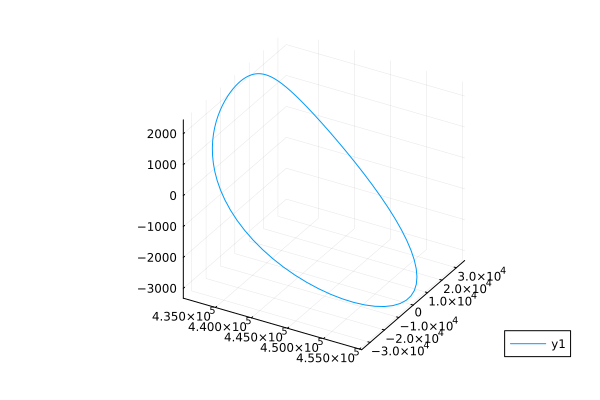

In [342]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [343]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [344]:
final_norm

6-element Vector{Float64}:
  0.00322519987821579
 -0.003851463980650329
  7.884718979767058e-5
  0.002199234649276377
 -0.001440918504158617
  0.0001293855647662

In [345]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([431249.946141646 431249.94614368404 … 431254.2560939666 431253.84210558556; 0.0 2.11865931416171 … -1155.147976497463 -4.216680720506682; … ; 15649.01638927097 15649.016351075303 … 15636.011893022314 15647.275815398147; 0.0 -0.09679750259452195 … 52.71954343616217 0.15311785966204014], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393e

In [346]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([431249.946141646 431249.94614368404 … 554005.2428719949 557288.0105173714; 0.0 2.11865931416171 … -69190.52364549524 -75399.30097688234; … ; 15649.01638927097 15649.016351075303 … -46181.103118709194 -47985.92575257201; 0.0 -0.09679750259452195 … -761.2070424352357 -752.7103722662881], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.74681260289577e-14 … 4.21449737713891e-9 1.5618013565683038e-14; -2.1789856876862402e-14 0.9999999976191183 … 0.0001353861009620931 7.747326020150754e-20; … ; -4.828381202874513e-10 -3.517173033319686e-5 … 0.9999999956810307 2.288957559459435e-15; 5.112447756761017e-6 1.0493422150552927e-10 … 1.6653222599682134e-14 0.9999999971499303;;; 1.0000000245547165 4.529417817983927e-13 … 1.6691269091577298e-8 1.2309520780151584e-13; -1.7173931605969936e-13 0.999999990570658 … 0.0002694299455112233 1.2151753729360987e-18; … ; -1.9122519702650388e-9 -6.999475781107277e-5 … 0.9999999828949762 1.8040687294144393e

In [347]:
all_state_lp

6×333 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …       5.54005e5  557288.0
     0.0           2.11866        4.21631       -69190.5        -75399.3
  2286.77       2286.77        2286.77           -2892.26        -2992.08
     0.0           0.0301068      0.0599152      25052.3         24725.6
 15649.0       15649.0        15649.0           -46181.1        -47985.9
     0.0          -0.0967975     -0.192635   …    -761.207        -752.71

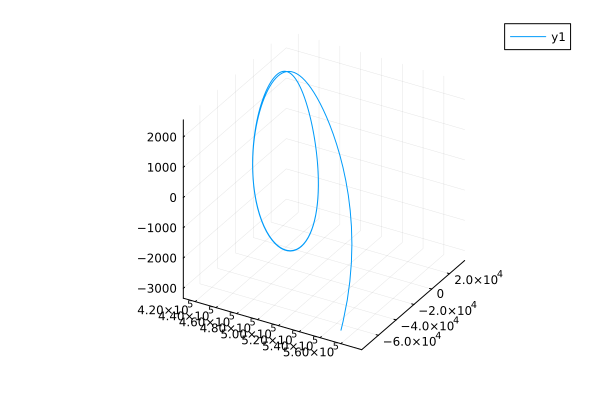

In [348]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

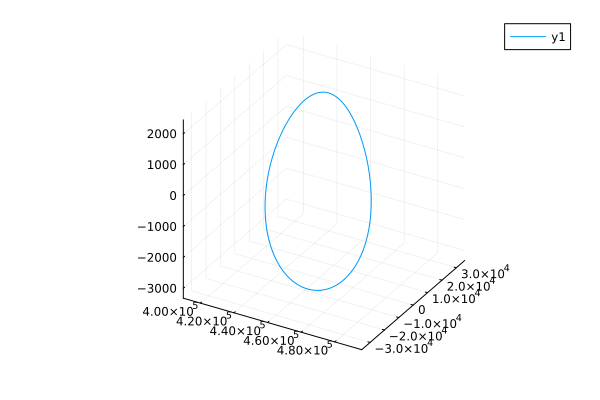

In [349]:
plot(all_state_2[1,:], all_state_2[2,:], all_state_2[3,:], aspectratio=true)

In [350]:
all_state_2

6×216 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.31254e5      4.31254e5
     0.0           2.11866        4.21631       -1155.15          -4.21668
  2286.77       2286.77        2286.77           2284.92        2286.86
     0.0           0.0301068      0.0599152       -13.9857         2.65783
 15649.0       15649.0        15649.0           15636.0        15647.3
     0.0          -0.0967975     -0.192635   …     52.7195         0.153118

In [351]:
all_state_final

6×131 Matrix{Float64}:
     4.3125e5      4.3125e5       4.3125e5   …      4.3125e5      4.3125e5
     0.0           2.11866        4.21631        -974.27         -0.00385146
  2286.77       2286.77        2286.77           2285.38       2286.77
     0.0           0.0301068      0.0599152       -13.9354        0.00219923
 15649.0       15649.0        15649.0           15640.9       15649.0
     0.0          -0.0967975     -0.192635   …     44.5037        0.000129386

In [352]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [353]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [354]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [355]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [356]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

#N_h = 82 #horizon 2 periods

N_h = 81 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.3713042889610444

In [357]:
all_state_final[:,1]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
  15649.01638927097
      0.0

In [358]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [359]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [360]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [361]:
#umin = 0.5
#umax = 1

In [362]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [363]:
T_corrected = sol_t_final[end]

14.852171558441775

In [364]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [365]:
horizon[2]

0.3713042889610444

In [366]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [367]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [368]:
full_solution(horizon).u[1][7:end]

36-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [369]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [370]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
  0.5935997677778411
 -0.6423215383474878
  0.013967734765510597
  0.40497424701619056
 -0.265176994172325
  0.023329819329140137

In [371]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [372]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [373]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [374]:
#[unstable_directions[1:3, 1]; zeros(3)]

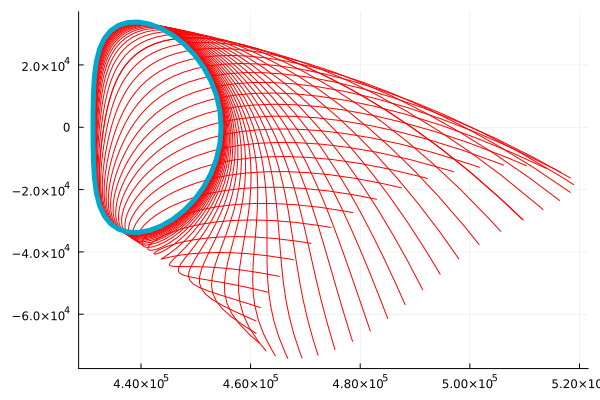

In [375]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit")


for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold = just_dynamics_integrate(initial_state, 1.5*sol_t_final[end])

    all_state_m = get_state(inv_manifold)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_m[1,:], all_state_m[2,:], color="red", legend=false)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Orbit", linewidth = 5)


In [376]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

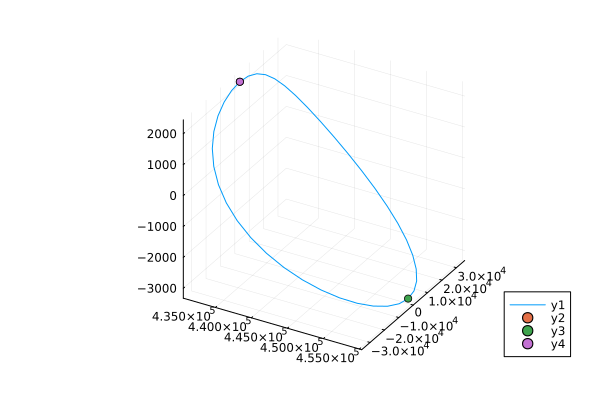

In [377]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [378]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [379]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [380]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = u/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [381]:
sol_t_final[end]

14.852171558441775

In [382]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    f1 = three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end



RK4_integrator (generic function with 1 method)

In [383]:
reference_trajectory

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00385146
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00219923
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129386

In [384]:
u0 = zeros(3)
Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

6×6 Matrix{Float64}:
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

In [385]:
Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

6×3 Matrix{Float64}:
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

In [386]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    #Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])
    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    #Bk = [zeros(3,3); I]

    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))

    #this is the A tilde to get the discretized dynamics
    # Ãk = [Ak Bk; zeros(3,9)]

    # H = exp(Ãk*Δt)

    # all_Ad[:,:,i] = H[1:nx, 1:nx]

    # all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [387]:
all_Bd[:,:,1]

6×3 Matrix{Float64}:
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

In [388]:
all_Ad[:,:,1] 

6×6 Matrix{Float64}:
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

In [389]:
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63571e-5
 -0.00381906   0.0685871   4.37093e-6
  2.63571e-5   4.37093e-6  0.0686965
  0.374737     0.0330256   0.000274268
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31595e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75985e-6
  2.14464e-5   5.75985e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32537e-5
  0.000214041  7.17612e-5  0.368954

;;; … 

[:, :, 79] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35713e-6
  2.63732e-5   -4.35713e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296047  -2.75461e-5   0.368724

[

In [390]:
#concatenate jacobians for two periods

# all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
# all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [391]:
N_period

41

In [392]:
num_revs = 10

10

In [393]:
#1 revolution is 14 days
#T*time_scale/60/60/24

In [394]:
N_h

81

In [395]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)


#state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-3

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-3

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e3

3×3 Matrix{Float64}:
 1000.0     0.0     0.0
    0.0  1000.0     0.0
    0.0     0.0  1000.0

In [396]:
N_period+((N_period-1)*15)

641

In [397]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 639] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 640] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [398]:
#1:(N_period*num_revs) - 1

In [399]:
#all_Ad_rev = all_Ad

In [400]:
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0692973    0.00396111  2.93345e-5
 -0.00388576   0.0685635   1.65086e-6
  2.93345e-5   1.65086e-6  0.0686883
  0.375142     0.032364    0.000311353
 -0.0311828    0.367385    1.241e-5
  0.000309142  3.89267e-5  0.36868

[:, :, 2] =
  0.0692656    0.00402781  2.63571e-5
 -0.00381906   0.0685871   4.37093e-6
  2.63571e-5   4.37093e-6  0.0686965
  0.374737     0.0330256   0.000274268
 -0.030512     0.367682    3.99156e-5
  0.000269826  6.31595e-5  0.368787

[:, :, 3] =
  0.0692132    0.00407449  2.14464e-5
 -0.00377237   0.068625    5.75985e-6
  2.14464e-5   5.75985e-6  0.0687109
  0.374151     0.0334585   0.00021943
 -0.0300649    0.368102    5.32537e-5
  0.000214041  7.17612e-5  0.368954

;;; … 

[:, :, 39] =
  0.0692656     0.00381945   2.63732e-5
 -0.00402742    0.068587    -4.35713e-6
  2.63732e-5   -4.35713e-6   0.0686965
  0.374973      0.0308243    0.000292584
 -0.0327187     0.367509    -5.26963e-5
  0.000296047  -2.75461e-5   0.368724

[

In [401]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end


In [402]:
# all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
# all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

# all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
# all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

# all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
# all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

In [403]:
# for i = 1:num_revs
#     all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
# end

In [404]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [405]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [406]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698

In [407]:
P[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

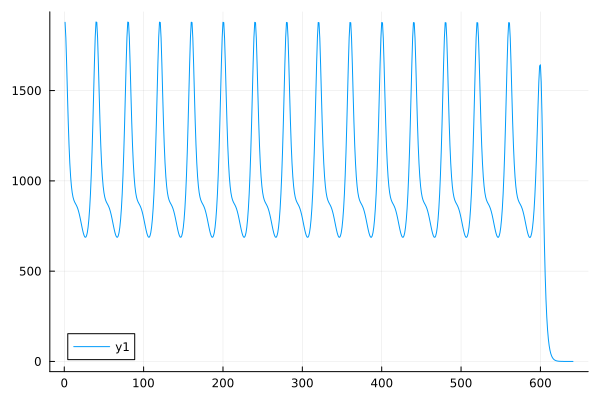

In [408]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [409]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698 

In [410]:
V[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [411]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

[:, :, 2] =
 1791.63    126.901    53.8867   1481.15    1744.4     21.3351
  126.901     9.15195   3.84318   105.423    123.276    1.47771
   53.8867    3.84318   1.87429    44.7436    52.3419  -0.11799
 1481.15    105.423    44.7436   1229.03    1437.68    17.2838
 1744.4     123.276    52.3419   1437.68    1703.26    20.4681
   21.3351    1.47771  -0.11799    17.2838    20.4681   9.94354

[:, :, 3] =
 1647.31     231.473     41.7948    1360.5      1708.33     5.49429
  231.473     32.6689     5.87698    191.238     240.263    0.714936
   41.7948     5.87698 

In [412]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [413]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [414]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0           2.089e-12     9.23706e-13  …   2.50111e-12  -1.45661e-12
 -2.089e-12     0.0          -1.82299e-13      1.20082e-12   4.11171e-13
 -9.23706e-13   1.82299e-13   0.0              6.39488e-13   1.67533e-13
 -1.36424e-12   3.78719e-12   1.54898e-12      5.68434e-12  -2.08544e-12
 -2.50111e-12  -1.20082e-12  -6.39488e-13      0.0           1.00897e-12
  1.45661e-12  -4.11171e-13  -1.67533e-13  …  -1.00897e-12   0.0

In [415]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0           1.84741e-12   5.96856e-13  …   2.27374e-12  -1.39977e-12
 -1.84741e-12   0.0          -1.62537e-13      1.36424e-12   6.03961e-13
 -5.96856e-13   1.62537e-13   0.0              5.18696e-13   1.87905e-13
 -1.13687e-12   3.87956e-12   1.09424e-12      5.91172e-12  -1.9682e-12
 -2.27374e-12  -1.36424e-12  -5.18696e-13      0.0           1.20792e-12
  1.39977e-12  -6.03961e-13  -1.87905e-13  …  -1.20792e-12   0.0

In [416]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [417]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
 120.482    125.0       3.03034   -81.6922   -54.3617   -4.69887
 125.0      137.863     2.85079   -85.4866   -55.6143   -4.92428
   3.03034    2.85079   4.87823    -2.23434   -1.39923   0.801581
 -81.6922   -85.4866   -2.23434    55.5254    36.7336    3.14874
 -54.3617   -55.6143   -1.39923    36.7336    24.6556    2.11428
  -4.69887   -4.92428   0.801581    3.14874    2.11428   0.473454

In [418]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0          -2.84217e-12   5.75096e-13  …  -3.62377e-13   6.66134e-14
  2.84217e-12   0.0           6.42153e-13     -1.66978e-12  -4.70735e-14
 -5.75096e-13  -6.42153e-13   0.0              2.51799e-13   2.43139e-14
 -3.69482e-13   1.56319e-12  -3.92575e-13      4.1922e-13   -2.93099e-14
  3.62377e-13   1.66978e-12  -2.51799e-13      0.0          -4.44089e-14
 -6.66134e-14   4.70735e-14  -2.43139e-14  …   4.44089e-14   0.0

In [419]:
display(V_first)

6×6 Matrix{Float64}:
 1878.27    -20.1674    62.6185    1595.77    1718.6     37.9722
  -20.1674    0.493182  -0.628398   -16.2136   -19.199   -0.395413
   62.6185   -0.628398   2.63074     53.4446    57.2065  -0.422925
 1595.77    -16.2136    53.4446    1360.09    1455.77    31.9983
 1718.6     -19.199     57.2065    1455.77    1577.38    34.3169
   37.9722   -0.395413  -0.422925    31.9983    34.3169   9.52338

In [420]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [421]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [422]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [423]:
x_initial_ref_scaled'*V[:,:,1]*x_initial_ref_scaled

0.0004079123354540811

In [424]:
V[:,:,20]

6×6 Matrix{Float64}:
  794.569   -252.913    -23.5578   1300.91     504.658   -26.2258
 -252.913     80.7081     7.56067  -413.675   -161.035     8.04713
  -23.5578     7.56067    1.14244   -38.6294   -14.9543   -1.35379
 1300.91    -413.675    -38.6294   2132.99     821.921   -42.3328
  504.658   -161.035    -14.9543    821.921    326.976   -16.9576
  -26.2258     8.04713   -1.35379   -42.3328   -16.9576   14.9996

In [425]:
V[:,:,end]

6×6 Matrix{Float64}:
 1877.92    -20.2159    62.5995    1595.12    1718.71    37.8908
  -20.2159    0.484219  -0.633542   -16.3083   -19.1852  -0.394736
   62.5995   -0.633542   2.60357     53.3928    57.215   -0.26388
 1595.12    -16.3083    53.3928    1358.85    1455.98    31.9482
 1718.71    -19.1852    57.215     1455.98    1577.34    34.3221
   37.8908   -0.394736  -0.26388     31.9482    34.3221   8.37533

In [426]:
test = eigen(V[:,:,20]).values

6-element Vector{Float64}:
    0.0034536236353028974
    0.11723570599835496
    0.2199819984365143
    9.069440179687561
   14.525283597421641
 3327.447516951693

In [427]:
1/sqrt(test[6])

0.017335820156121864

In [428]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
  0.5936      0.630003    0.669871    0.709854   …   0.563902     0.5936
 -0.642322   -0.611253   -0.574696   -0.534157      -0.666939    -0.642322
  0.0139677   0.0196798   0.024741    0.028827       0.00797906   0.0139677
  0.404974    0.424713    0.434908    0.43676        0.376944     0.404974
 -0.265177   -0.21929    -0.175043   -0.136631      -0.307627    -0.265177
  0.0233298   0.0246805   0.0244821   0.0229326  …   0.0205333    0.0233298

In [429]:
# V_2orbits

In [430]:
Xm[:,end]'*P[:,:,end]*Xm[:,end]

7.953790461765869e-7

In [431]:
#cost to go level set
epsilon = 1e-2

umax = 0.025

0.025

In [432]:
tube_pose_r = 1e-5
tube_vel_r = 1e-5

1.0e-5

In [433]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [434]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [435]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [436]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [437]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [438]:
# dot(test, unstable_directions[:,1])

In [439]:
# L

In [440]:
# dot(x_initial_ref, unstable_directions[:,1])

In [441]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.04672       0.00116552   0.00258833   …  0.03218     0.000318583
 -0.000431504   0.982282    -5.0311e-5       0.367318    4.24364e-6
  0.00259016    9.59182e-5   0.978703        3.13769e-5  0.368663
  0.252156      0.00924403   0.0138642       0.17581     0.00254655
 -0.00360089   -0.0944522   -0.000409083     0.968211    4.27982e-5
  0.0138817     0.00076016  -0.113972     …  0.00033015  0.978825

[:, :, 2] =
 1.04471      0.00728049    0.00238289   …  0.0328983    0.000287544
 0.00571035   0.983671      0.000212577     0.367573     3.5243e-5
 0.00236898   0.000348162   0.979299        5.96173e-5   0.368751
 0.239938     0.0413802     0.0125897       0.181322     0.00226528
 0.0287575   -0.0863362     0.000965359     0.970499     0.000278993
 0.0124803    0.0020421    -0.110212     …  0.000534113  0.979635

[:, :, 3] =
 1.0406       0.0118637     0.00198334  …  0.0333965    0.00023489
 0.0103511    0.986562      0.00037818     0.367985     5.2

In [442]:
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00385146
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00219923
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000129386

In [443]:
#dynamics_wcontrol_integrate([reference_trajectory2[:,1]; zeros(3)], Δt).u[end][1:6]

In [444]:
#formulate the problem at every solve


#pass in the initial condition, along with jacobians of the current reference trajectory 

#bias is a 6xN_h-1 matrix
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, bias)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint with bias
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        #check sign on the bias. parenthesis
        #push!(cons, zeros(6)== X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k] - bias[:,k])
        
        #kinda working
        #push!(cons, zeros(6)== X[:,k+1] - (all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        #Linear affine term in terms of Δx and Δu (the integrator is there because the reference trajectory is not dynamically feasible)
        #(x̄+Δx) - (f(x̄,ū) + AΔx + BΔu) - bias
        push!(cons, zeros(6)== reference_trajectory2[:,k+1] + X[:,k+1] - (dynamics_wcontrol_integrate([reference_trajectory2[:,k]; zeros(3)], Δt).u[end][1:6] + all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        
        #in terms of x's
        #prob.constraints += X[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*(X[:,i] - X̄[i]) + B[i]*(U[:,i] - Ū[i])
        #in terms of deltas
        #prob.constraints += X̄[i+1] + ΔX[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*ΔX[:,i] + B[i]*ΔU[:,i]


    end

    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS
    # for k=2:N_h 
    #    push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
    #    push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    # end
    
    
    #cost to go constraint (working)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end



# for k = 2:N_h
for k = 1:N_h
            
    #manifold goes to the right
    #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    manifold_constraint = X[:,k]'*unstable_directions_k[:,k]
    
    #currently working
    #push!(cons, manifold_constraint > 0)

    #add some slack
    push!(cons, manifold_constraint > 1e-6)
    
end

   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#currently the one being used
# for k=2:N_h
        
#     #works with pi/5 too
#     c = unstable_directions_k[:,k]/tan(pi/6)
#     #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

#     manifold_constraint = norm(X[:,k]) - c'*X[:,k]

#     push!(cons, manifold_constraint <= 0)

# end

    
     
    #Controls Constraint
    
    # for k=1:(N_h-1)
        
    #   push!(cons, norm(U[1:3, k]) <= umax)

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end
    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [445]:
unstable_directions[:,1]

6-element Vector{Float64}:
  0.5935997677778412
 -0.642321538347488
  0.013967734765510598
  0.4049742470161906
 -0.26517699417232504
  0.02332981932914014

In [446]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)
        obj += norm(U[:,k], 1) + 1e2*norm(X[:,k], 1) 
        #obj += norm(X[:,k], 2) 
        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver= true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [447]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [448]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [449]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
 -0.00322519987821579
  0.003851463980650329
 -7.884718979767058e-5
 -0.002199234649276377
  0.001440918504158617
 -0.0001293855647662

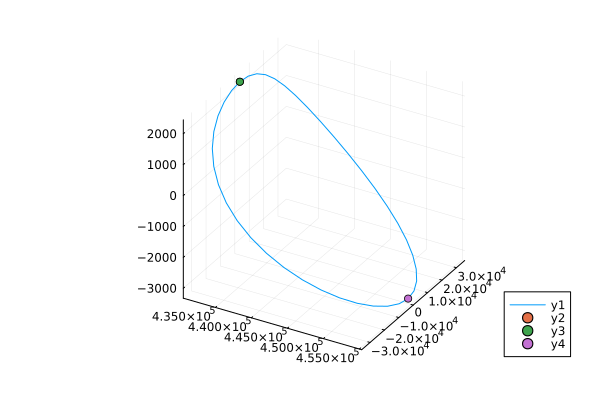

In [450]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [451]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-9
 0.0
 0.0
 0.0
 1.0e-9
 0.0

In [452]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [453]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [454]:
N_h

81

In [455]:
#just test to see if it solves

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)
bias_0 = zeros(6, N_h-1)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, bias_0)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 530…537

OPTIMAL::TerminationStatusCode = 1

([0.00038500000000000003 0.00038730670011555523 … 0.0013698372615837768 -0.00039501017299048744; 0.0 -3.414831348945523e-5 … -0.000272317433520998 -7.183474360156536e-5; … ; 8.852345449302067e-5 -0.00027027451996355115 … 5.276054252777701e-18 -0.0019793923859901183; 0.0 -4.694445463775548e-17 … -5.777214890552306e-18 -0.0001887910517984011], [-0.00021455843663590425 0.0007121610537403616 … 0.0008502794596932357 0.003393598388492332; -0.0009844769610686485 -4.3764690494382175e-17 … -0.004885321499000528 0.0; -1.4194791978615367e-5 9.404146582690162e-5 … 2.148828656562358e-5 0.0])

In [456]:
Um

3×80 Matrix{Float64}:
 -0.000214558   0.000712161  -0.000494468  …   0.000850279  0.0033936
 -0.000984477  -4.37647e-17   0.000860728     -0.00488532   0.0
 -1.41948e-5    9.40415e-5   -4.14205e-5       2.14883e-5   0.0

In [457]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [458]:
constraint_satisfied[1]

0.00020506152701825904

In [459]:
constraint_satisfied[15]

0.0004073422282202328

In [460]:
Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
 -0.46260340244852505
 -0.542267435333783
  0.02748190581236508
  0.70084867515926
 -1.959828963529959e-14
  7.495422005335417e-15

In [461]:
unstable_directions[:,18]

6-element Vector{Float64}:
  0.8763990557853825
 -0.253324931452996
 -0.003152202237007567
  0.3829713680353936
 -0.14467125717389165
 -0.01201650351419272

In [462]:
constraint_satisfied[60:70]

11-element Vector{Float64}:
 9.99999985590869e-7
 0.005405544154503273
 9.999999999511539e-7
 0.004040779524273093
 9.999999999471966e-7
 0.0009808725546646276
 6.0713223501324205e-5
 9.999999999784487e-7
 0.0011801553058220701
 9.999999999584994e-7
 0.0006547416377171802

In [463]:
constraint_satisfied

81-element Vector{Float64}:
 0.00020506152701825904
 0.0003241474375026301
 0.00033610347058645937
 0.0003573840715641728
 0.0003934936144603051
 9.999999999170828e-7
 0.001135952833195354
 0.0013220893564970158
 0.0007529905842049036
 1.0000000000018675e-6
 ⋮
 1.0000000003144971e-6
 9.999999999452179e-7
 9.999999999424532e-7
 9.999999999368153e-7
 0.0003496699713097122
 9.99999999982135e-7
 0.0005820401025141696
 0.0009550081455795565
 1.0000000002660333e-6

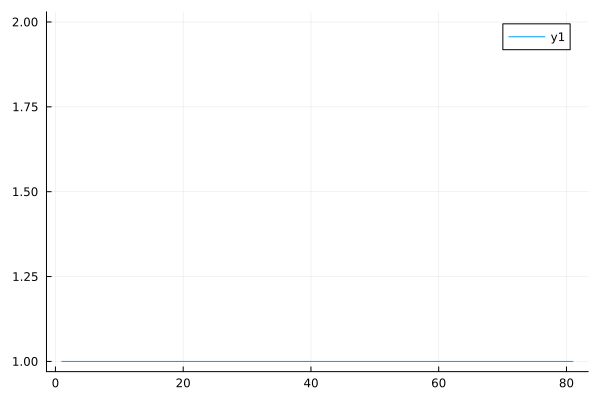

In [464]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

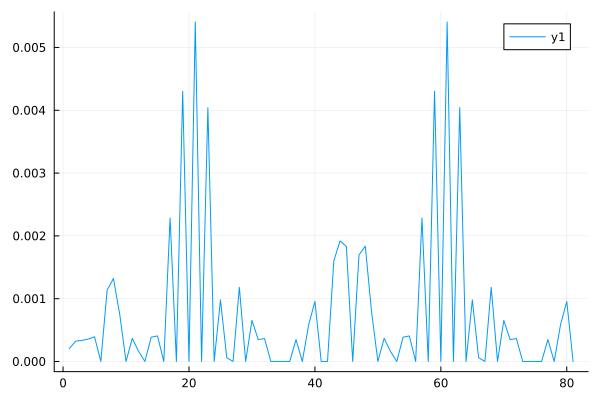

In [465]:
plot(constraint_satisfied)

In [466]:
constraint_satisfied

81-element Vector{Float64}:
 0.00020506152701825904
 0.0003241474375026301
 0.00033610347058645937
 0.0003573840715641728
 0.0003934936144603051
 9.999999999170828e-7
 0.001135952833195354
 0.0013220893564970158
 0.0007529905842049036
 1.0000000000018675e-6
 ⋮
 1.0000000003144971e-6
 9.999999999452179e-7
 9.999999999424532e-7
 9.999999999368153e-7
 0.0003496699713097122
 9.99999999982135e-7
 0.0005820401025141696
 0.0009550081455795565
 1.0000000002660333e-6

In [467]:
constraint_bool[44]

true

In [468]:
Xm 

6×81 Matrix{Float64}:
 0.000385     0.000387307   0.000519512  …   0.00136984   -0.00039501
 0.0         -3.41483e-5    7.17644e-5      -0.000272317  -7.18347e-5
 0.0          6.34984e-8    2.94438e-5       0.00011714   -0.000213894
 0.0         -1.28431e-17  -4.42513e-18     -4.32657e-18  -0.000810324
 8.85235e-5  -0.000270275  -0.000163456      5.27605e-18  -0.00197939
 0.0         -4.69445e-17  -1.7101e-17   …  -5.77721e-18  -0.000188791

In [469]:
residual = zeros(6, N_h-1)

6×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [470]:
reference_trajectory[:,1]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.769716989665
      0.0
  15649.01638927097
      0.0

In [471]:
reference_trajectory[:,end]

6-element Vector{Float64}:
 431249.9493668459
     -0.003851463980650329
   2286.769795836855
      0.002199234649276377
  15649.014948352466
      0.0001293855647662

In [472]:
input = [Xm[:,1] + reference_trajectory[:,1]; Um[:,1]]

9-element Vector{Float64}:
 431249.94652664603
      0.0
   2286.769716989665
      0.0
  15649.016477794425
      0.0
     -0.00021455843663590425
     -0.0009844769610686485
     -1.4194791978615367e-5

In [473]:
#reference_trajectory2 = [reference_trajectory reference_trajectory]

In [474]:
#find the residual

for k = 1:N_h-1

    input = [Xm[:,k] + reference_trajectory2[:,k]; Um[:,k]]

    xnext_sol = dynamics_wcontrol_integrate(input, Δt)

    residual[:,k] = reference_trajectory2[:,k+1] + Xm[:,k+1] - xnext_sol.u[end][1:6]

end

In [475]:
residual

6×80 Matrix{Float64}:
  1.19326e-8    1.74623e-10  -1.14669e-8   …   4.97676e-8   -6.92671e-9
  7.17318e-9    8.43829e-9    1.44064e-9       4.70209e-10   1.47793e-8
  1.23418e-9   -1.25056e-10  -1.14187e-9       5.15183e-9   -1.02273e-9
  4.81138e-9   -1.72723e-8   -1.0467e-8       -9.35503e-8   -1.26843e-7
 -8.1327e-9    -8.21638e-9    4.04361e-9      -1.52795e-8    8.72933e-9
  5.91172e-12  -1.89453e-9   -8.59586e-10  …  -7.0815e-9    -9.38278e-9

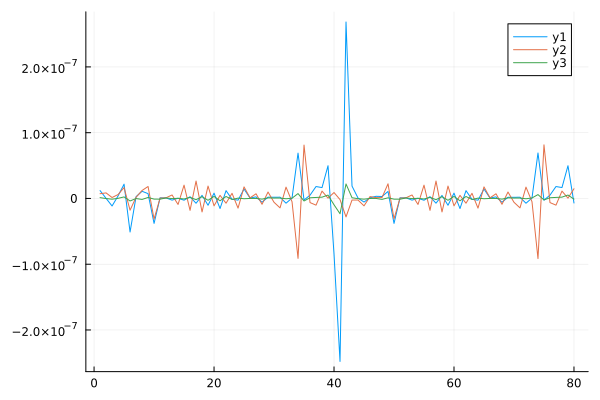

In [476]:
plot(residual[1,:])
plot!(residual[2,:])
plot!(residual[3,:])

In [477]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00356558
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00289282
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000130107

In [478]:
Xm[:,1]

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [479]:
delta_test = xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 0.000385     0.000387295   0.000519497  …   0.00138389   -0.000112532
 0.0         -3.41555e-5    7.1752e-5       -0.000288232   0.000285883
 0.0          6.2264e-8     2.94426e-5       0.000166701  -0.000129039
 0.0         -4.81138e-9    1.06311e-8       9.32795e-6    0.000693583
 8.85235e-5  -0.000270266  -0.000163438     -7.41224e-6   -7.93525e-6
 0.0         -5.91172e-12   1.85486e-9   …   5.08638e-7    7.21615e-7

In [480]:
dot(delta_test[:,1], unstable_directions[:,1])

0.0002050615394912348

In [481]:
delta_test - Xm[:,1:41]

6×41 Matrix{Float64}:
 2.11969e-11  -1.19583e-8   -1.43097e-8  …   1.37249e-5   1.77917e-5
 0.0          -7.17341e-9   -1.24255e-8     -1.59132e-5  -1.87697e-5
 0.0          -1.23436e-9   -1.11635e-9      1.77965e-7   4.12302e-7
 0.0          -4.81138e-9    1.06311e-8      9.32795e-6   1.24216e-5
 4.12933e-13   8.13215e-9    1.71602e-8     -7.41224e-6  -7.93525e-6
 0.0          -5.91167e-12   1.85486e-9  …   5.08638e-7   7.21615e-7

In [482]:
xtraj_test[:,1] - reference_trajectory[:,1]

6-element Vector{Float64}:
 0.0003850000211969018
 0.0
 0.0
 0.0
 8.852345490595326e-5
 0.0

In [483]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [484]:
delta_test[:,1]

6-element Vector{Float64}:
 0.0003850000211969018
 0.0
 0.0
 0.0
 8.852345490595326e-5
 0.0

In [485]:
Xm[:,1]

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [486]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

In [487]:
delta_test[:,21]

6-element Vector{Float64}:
  0.006327510986011475
 -1.0685513484461497e-5
 -0.00020896980322504533
  2.238546301214811e-7
 -1.232929207617417e-7
 -1.28285040686586e-8

In [488]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 0.0002050615394912348
 0.000324140437315216
 0.00033610266337243615
 0.0003573964970163323
 0.00039350713251955693
 1.0134770589265542e-6
 0.001136017948018831
 0.0013221800746850124
 0.0007530964625354776
 1.1215120874674602e-6
 ⋮
 6.899360034200901e-6
 8.117418456824615e-6
 9.559035562242517e-6
 1.154405794909219e-5
 0.00036234215469665694
 1.6942860168299694e-5
 0.0006019514851111634
 0.0009797500999441852
 3.077458894470083e-5

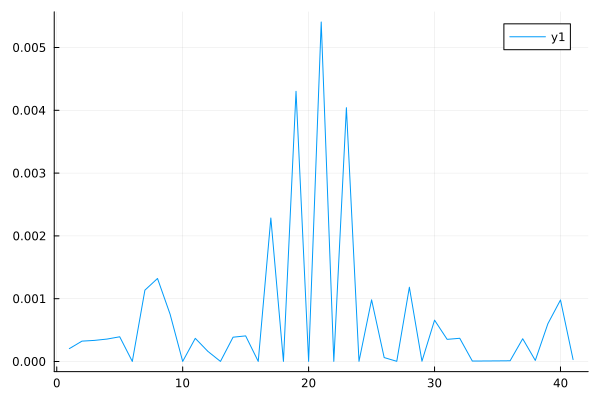

In [489]:
plot(constraint_satisfied_ndynamics)

In [490]:
constraint_satisfied

81-element Vector{Float64}:
 0.00020506152701825904
 0.0003241474375026301
 0.00033610347058645937
 0.0003573840715641728
 0.0003934936144603051
 9.999999999170828e-7
 0.001135952833195354
 0.0013220893564970158
 0.0007529905842049036
 1.0000000000018675e-6
 ⋮
 1.0000000003144971e-6
 9.999999999452179e-7
 9.999999999424532e-7
 9.999999999368153e-7
 0.0003496699713097122
 9.99999999982135e-7
 0.0005820401025141696
 0.0009550081455795565
 1.0000000002660333e-6

In [491]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
 0.0002050615394912348
 0.000324140437315216
 0.00033610266337243615
 0.0003573964970163323
 0.00039350713251955693
 1.0134770589265542e-6
 0.001136017948018831
 0.0013221800746850124
 0.0007530964625354776
 1.1215120874674602e-6
 ⋮
 6.899360034200901e-6
 8.117418456824615e-6
 9.559035562242517e-6
 1.154405794909219e-5
 0.00036234215469665694
 1.6942860168299694e-5
 0.0006019514851111634
 0.0009797500999441852
 3.077458894470083e-5

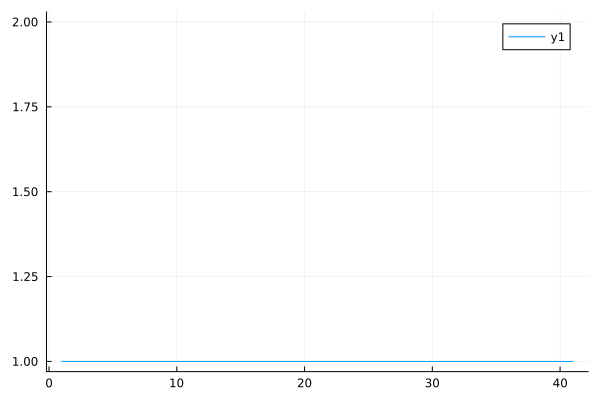

In [492]:
plot(constraint_satisfied_ndynamics .>0)

In [493]:
final = Xm + [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.0039233
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00138891
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025     -5.94055e-5

In [494]:
residual

6×80 Matrix{Float64}:
  1.19326e-8    1.74623e-10  -1.14669e-8   …   4.97676e-8   -6.92671e-9
  7.17318e-9    8.43829e-9    1.44064e-9       4.70209e-10   1.47793e-8
  1.23418e-9   -1.25056e-10  -1.14187e-9       5.15183e-9   -1.02273e-9
  4.81138e-9   -1.72723e-8   -1.0467e-8       -9.35503e-8   -1.26843e-7
 -8.1327e-9    -8.21638e-9    4.04361e-9      -1.52795e-8    8.72933e-9
  5.91172e-12  -1.89453e-9   -8.59586e-10  …  -7.0815e-9    -9.38278e-9

In [495]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [496]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

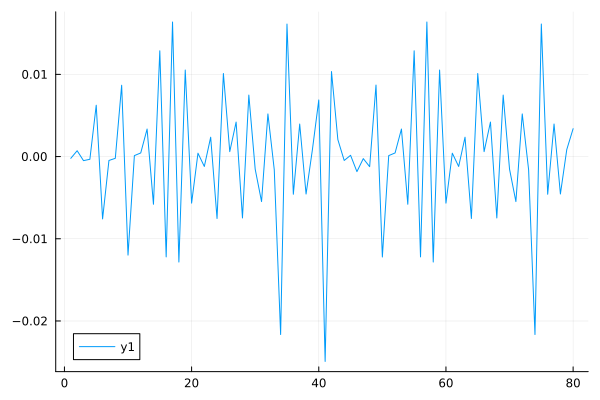

In [497]:
plot(Um[1,:])

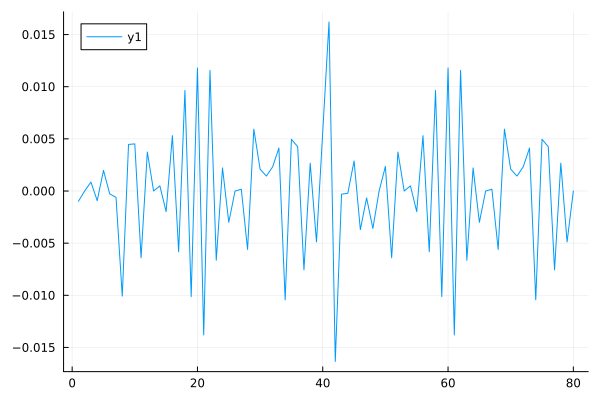

In [498]:
plot(Um[2,:])

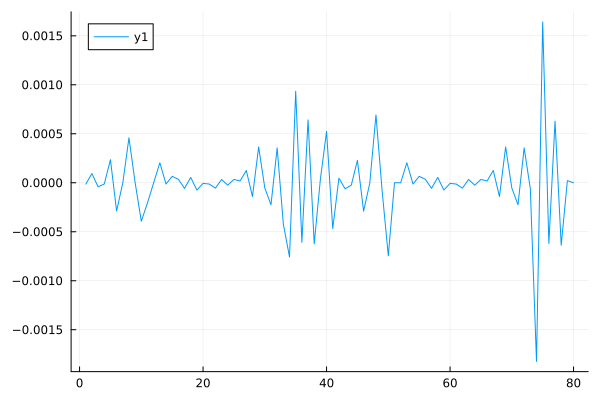

In [499]:
plot(Um[3,:])

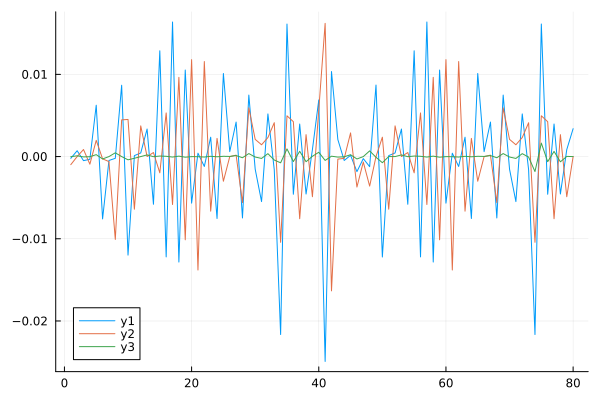

In [500]:
plot(Um[1,:])
plot!(Um[2,:])
plot!(Um[3,:])

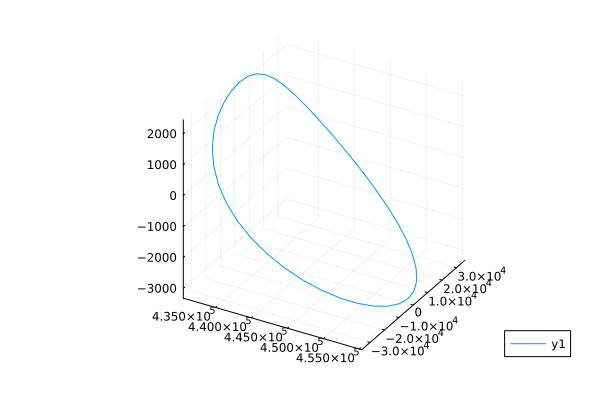

In [501]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
#scatter!([final[1,1]], [final[2,1]], [final[3,1]])

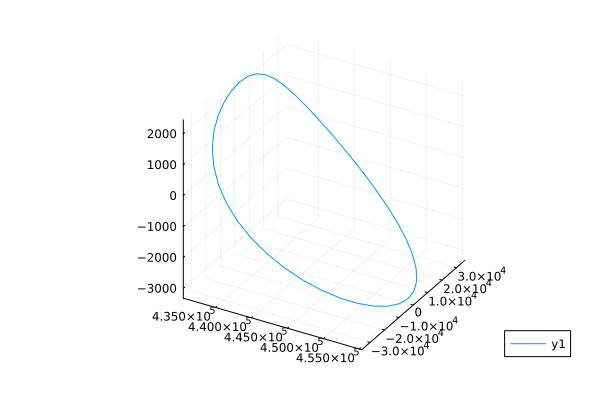

In [502]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [503]:
xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 0.000385     0.000387295   0.000519497  …   0.00138389   -0.000112532
 0.0         -3.41555e-5    7.1752e-5       -0.000288232   0.000285883
 0.0          6.2264e-8     2.94426e-5       0.000166701  -0.000129039
 0.0         -4.81138e-9    1.06311e-8       9.32795e-6    0.000693583
 8.85235e-5  -0.000270266  -0.000163438     -7.41224e-6   -7.93525e-6
 0.0         -5.91172e-12   1.85486e-9   …   5.08638e-7    7.21615e-7

In [504]:
unstable_directions[:,2]

6-element Vector{Float64}:
  0.630003179764346
 -0.6112533864355001
  0.01967984161511346
  0.4247126343639782
 -0.21928986496549674
  0.024680523231366634

In [505]:
norm(xtraj_test[:,41] - xtraj_test[:,1])

0.005559218760002572

In [506]:
residual

6×80 Matrix{Float64}:
  1.19326e-8    1.74623e-10  -1.14669e-8   …   4.97676e-8   -6.92671e-9
  7.17318e-9    8.43829e-9    1.44064e-9       4.70209e-10   1.47793e-8
  1.23418e-9   -1.25056e-10  -1.14187e-9       5.15183e-9   -1.02273e-9
  4.81138e-9   -1.72723e-8   -1.0467e-8       -9.35503e-8   -1.26843e-7
 -8.1327e-9    -8.21638e-9    4.04361e-9      -1.52795e-8    8.72933e-9
  5.91172e-12  -1.89453e-9   -8.59586e-10  …  -7.0815e-9    -9.38278e-9

In [507]:
#solve the problem again and pass in the residual as the bias in the dynamics constraint
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, residual)
display("solving")
display(X)
Xm2, Um2 = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 157…145

OPTIMAL::TerminationStatusCode = 1

([0.00038500000000000003 0.00038731781914871374 … 0.001369889546436616 -0.00039495178892183795; 0.0 -3.414366010486082e-5 … -0.00027231359152706577 -7.181715695825218e-5; … ; 8.852345449302067e-5 -0.0002702960549774984 … 3.001116150694269e-18 -0.0019793909346477742; 0.0 -2.670115295988172e-17 … -3.2861445700820766e-18 -0.00018879986275349911], [-0.00021456804457541822 0.0007122098872956755 … 0.0008505330911204635 0.003393751984771227; -0.0009845142567941273 -2.4901041565397417e-17 … -0.004885260106052756 0.0; -1.4194804272352996e-5 9.404656490437251e-5 … 2.1506382137957373e-5 0.0])

In [508]:
half_rev_control = Um2[1:3, 1:21]/acceleration_scale

3×21 Matrix{Float64}:
 -1.05417e-8    3.49907e-8   -2.42917e-8  …  -2.78315e-7   2.02324e-8
 -4.83689e-8   -1.22338e-21   4.22908e-8      5.79414e-7  -6.77999e-7
 -6.97386e-10   4.62048e-9   -2.03486e-9     -3.1775e-10  -6.44682e-10

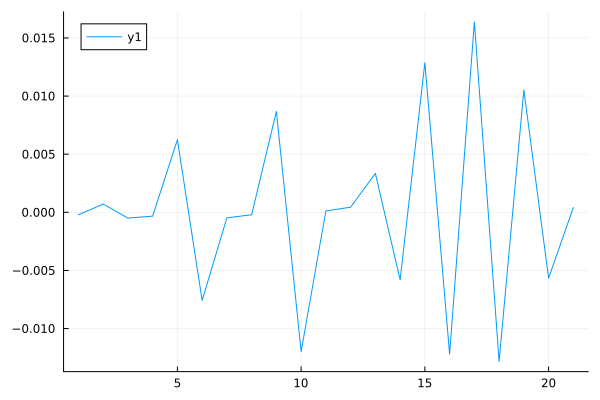

In [510]:
plot(Um2[1,1:21])

In [511]:
Um2[:,1]

3-element Vector{Float64}:
 -0.00021456804457541822
 -0.0009845142567941273
 -1.4194804272352996e-5

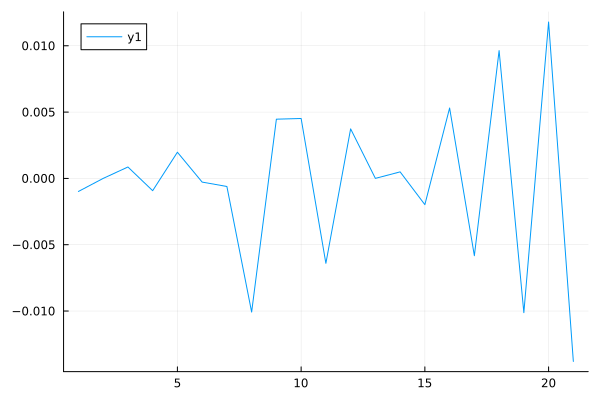

In [512]:
plot(Um2[2,1:21])

In [513]:
#plot(Um2[2,30:40])

In [514]:
#Um2[2, 32]

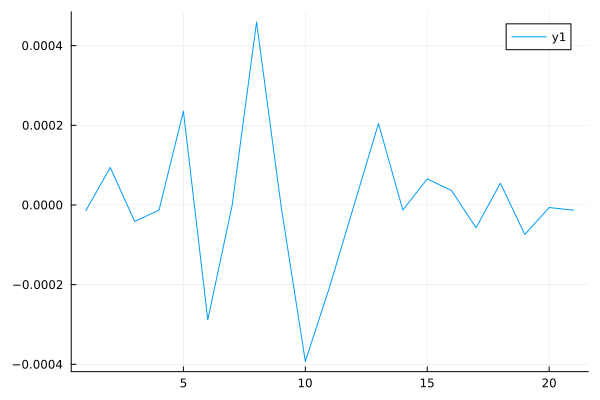

In [515]:
plot(Um2[3,1:21])

In [516]:
#for one period 40 controls
xtraj_test2 = integrate_oneperiod(Xm2[:,1] + reference_trajectory[:,1], Um2[:,1:40])

6×41 Matrix{Float64}:
     4.3125e5  431267.0        4.31338e5  …  431267.0        4.3125e5
     0.0         5775.21   11343.6            -5775.22      -0.00358476
  2286.77        2237.81    2094.63            2237.81    2286.77
     0.0          101.372    306.583           -101.372      0.00290549
 15649.0        15364.7    14545.9            15364.7    15649.0
     0.0         -262.025   -504.475      …     262.025      0.000130844

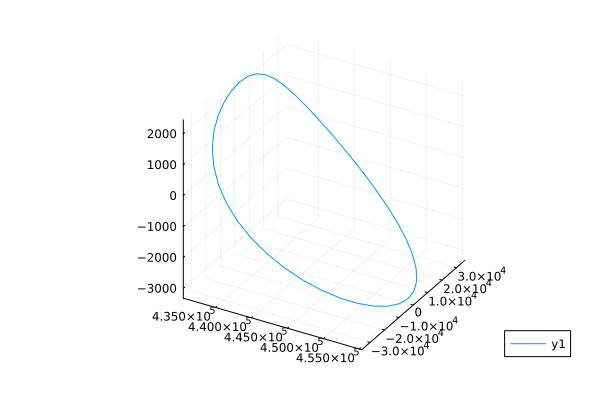

In [517]:
plot(xtraj_test2[1,:], xtraj_test2[2,:], xtraj_test2[3,:])
#scatter!([xtraj_test2[1,1]], [xtraj_test2[2,1]], [xtraj_test2[3,1]])

In [519]:
#similar to the first solve. No point in doing a second correction
norm(xtraj_test2[:,1] - xtraj_test2[:,41])

0.005589292018290069

In [520]:
#norm(xtraj_test2[:,41] - reference_trajectory[:,41])

In [521]:
#reference_trajectory[:,41]

In [522]:
#find if the updated solution satisfies the constraints
#delta_test2 = xtraj_test2 - reference_trajectory

In [523]:
end_state = xtraj_test2[:,21]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

6×226 Matrix{Float64}:
      4.5462e5         4.5462e5   …       5.16889e5       5.24256e5
      3.27731e-5      -1.68997       -47719.1        -54471.6
  -3158.04         -3158.04            2965.09         2920.09
      3.05063e-5      -0.375709       28623.4         29405.8
 -13831.2         -13831.2           -24791.8        -28458.6
     -4.66756e-7       0.0462638  …    -165.421        -188.819

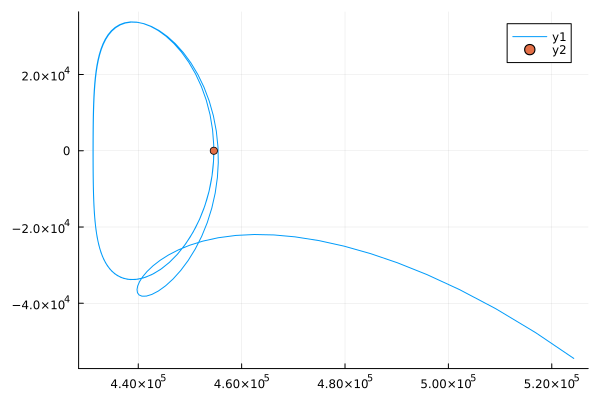

In [524]:
plot(end_state_traj[1,:],end_state_traj[2,:])
scatter!([end_state_traj[1,1]],[end_state_traj[2,1]])

In [525]:
# constraint_satisfied_ndynamics2 = zeros(41)

# for i=1:41
#     constraint_satisfied_ndynamics2[i] = dot(delta_test2[:,i], unstable_directions[:,i])
# end

In [526]:
# plot(constraint_satisfied_ndynamics2 .>0)

In [527]:
#fixed the reference trajectory and added some slack on the halfspace constraint and it seems like I don't need to use the second order correction
#anymore

In [528]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [529]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [530]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [531]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.02013      -0.000709133  -0.00082352   …   0.031622    -0.000101849
 -0.00159494    0.995426      6.51496e-5       0.368931     7.7217e-6
 -0.000826291   1.81356e-5    0.991778        -9.85875e-7   0.370285
  0.108365     -0.0057235    -0.00442342       0.169911    -0.000820395
 -0.0128926    -0.0243841     0.000525395      0.980834     8.3054e-5
 -0.00445321    0.000146447  -0.0442353    …  -1.07577e-5   0.991774

[:, :, 2] =
  1.01995      -0.00203182   -0.000808748  …  0.0314582   -9.98284e-5
 -0.00291862    0.995629      0.000117715     0.368949     1.41869e-5
 -0.000814518   7.14332e-5    0.991758        5.62796e-6   0.370282
  0.107069     -0.0127966    -0.00432351      0.168593    -0.000801069
 -0.0199745    -0.0229568     0.000803244     0.98101      0.00013438
 -0.00437718    0.000431073  -0.044365     …  4.23675e-5   0.991746

[:, :, 3] =
  1.01965      -0.00330381   -0.000780747  …  0.0313003  -9.61858e-5
 -0.00419301    0.995971    

In [532]:
all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.0689975    0.0039157   -9.47389e-6
 -0.00393117   0.0687129    3.13362e-7
 -9.47389e-6   3.13362e-7   0.0688387
  0.371993     0.0315803   -0.000101556
 -0.0318296    0.36893      9.38114e-6
 -0.000101985  6.98529e-7   0.370284

[:, :, 2] =
  0.068996     0.00390048  -9.31221e-6
 -0.00394639   0.0687147    9.19497e-7
 -9.31221e-6   9.19497e-7   0.0688384
  0.371973     0.0314174   -9.91153e-5
 -0.0319928    0.368953     1.57214e-5
 -0.000100092  7.2234e-6    0.37028

[:, :, 3] =
  0.0689933   0.00388581  -8.9976e-6
 -0.00396106  0.068718     1.47281e-6
 -8.9976e-6   1.47281e-6   0.0688378
  0.371941    0.0312614   -9.50906e-5
 -0.0321494   0.368993     2.13371e-5
 -9.6559e-5   1.3161e-5    0.370273

;;; … 

[:, :, 39] =
  0.068996      0.00394633  -9.31194e-6
 -0.00390054    0.0687147   -9.17085e-7
 -9.31194e-6   -9.17085e-7   0.0688384
  0.371985      0.0319116   -0.000101251
 -0.0314984     0.368939    -4.0069e-6
 -0.000100543  -1.26151e-5   

In [533]:
all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.0689975    0.0039157   -9.47389e-6
 -0.00393117   0.0687129    3.13362e-7
 -9.47389e-6   3.13362e-7   0.0688387
  0.371993     0.0315803   -0.000101556
 -0.0318296    0.36893      9.38114e-6
 -0.000101985  6.98529e-7   0.370284

[:, :, 2] =
  0.068996     0.00390048  -9.31221e-6
 -0.00394639   0.0687147    9.19497e-7
 -9.31221e-6   9.19497e-7   0.0688384
  0.371973     0.0314174   -9.91153e-5
 -0.0319928    0.368953     1.57214e-5
 -0.000100092  7.2234e-6    0.37028

[:, :, 3] =
  0.0689933   0.00388581  -8.9976e-6
 -0.00396106  0.068718     1.47281e-6
 -8.9976e-6   1.47281e-6   0.0688378
  0.371941    0.0312614   -9.50906e-5
 -0.0321494   0.368993     2.13371e-5
 -9.6559e-5   1.3161e-5    0.370273

;;; … 

[:, :, 79] =
  0.068996      0.00394633  -9.31194e-6
 -0.00390054    0.0687147   -9.17085e-7
 -9.31194e-6   -9.17085e-7   0.0688384
  0.371985      0.0319116   -0.000101251
 -0.0314984     0.368939    -4.0069e-6
 -0.000100543  -1.26151e-5   

In [534]:
#another set of jacobians if starting from half

#all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
#all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

#all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
#all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

In [535]:
#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
  772.894   -287.342    -22.3345    1291.56     457.86    -21.3223
 -287.342    106.992      8.35038   -479.972   -170.378     7.59879
  -22.3345     8.35038    0.921632   -37.3474   -13.2516   -0.988615
 1291.56    -479.972    -37.3474    2160.83     760.832   -35.0727
  457.86    -170.378    -13.2516     760.832    278.841   -12.9023
  -21.3223     7.59879   -0.988615   -35.0727   -12.9023   16.147

[:, :, 2] =
  750.793   -317.889    -20.813     1278.42     417.519    -16.0992
 -317.889    134.751      8.84188   -541.27    -176.63       6.4716
  -20.813      8.84188    0.737205   -35.4355   -11.6217    -0.523835
 1278.42    -541.27     -35.4355    2178.83     706.937    -26.9208
  417.519   -176.63     -11.6217     706.937    240.677     -9.17271
  -16.0992     6.4716    -0.523835   -26.9208    -9.17271   16.901

[:, :, 3] =
  729.762   -344.647    -19.0513     1263.51     384.303    -10.6507
 -344.647    162.942      9.00808    -596.833   -181.

In [536]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.00038500000000000003
 0.0
 0.0
 0.0
 8.852345449302067e-5
 0.0

In [537]:
unstable_directions_2[:,1]

6-element Vector{Float64}:
  0.5935997677778412
 -0.642321538347488
  0.013967734765510598
  0.4049742470161906
 -0.26517699417232504
  0.02332981932914014

In [538]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 1

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

solution_xm = zeros(6, 81, half_orbit_num)
solution_um = zeros(6, 80, half_orbit_num)


#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num
        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1        
    else
        println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
    end
    
    #the zeros is the bias 
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, zeros(6, N_h-1))
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

OPTIMAL::TerminationStatusCode = 1

using jacobian 1


OPTIMAL::TerminationStatusCode = 1

Half Revolution solved: 1
using jacobian 2
Half Revolution solved: 2


In [ ]:
#the current problem is that the linear problem does satisfy the dynamics, however, the nonlinear rollout breaks those dynamics. need second order
# correction for the MPC problem 

In [539]:
all_optimal_Δx

6×21×2 Array{Float64, 3}:
[:, :, 1] =
 0.000385     0.000387295   0.000519497  …  -0.00119243    0.00632751
 0.0         -3.41555e-5    7.1752e-5       -0.000719525  -1.06855e-5
 0.0          6.2264e-8     2.94426e-5       9.34952e-5   -0.00020897
 0.0         -4.81138e-9    1.06311e-8       0.00197184    2.23855e-7
 8.85235e-5  -0.000270266  -0.000163438     -0.000464838  -1.23293e-7
 0.0         -5.91172e-12   1.85486e-9   …  -9.66131e-9   -1.28285e-8

[:, :, 2] =
  0.00632751  -0.00239001    0.000566301  …  -0.065728     -0.0858928
 -1.06855e-5   0.00103647    0.000229083      0.0796148     0.0944971
 -0.00020897   0.00016469    3.11072e-5      -0.000764166  -0.00218679
  2.23855e-7  -0.0109318    -0.00415312      -0.0416514    -0.0585258
 -1.23293e-7   0.00312187    0.000852125      0.0368048     0.0400565
 -1.28285e-8   0.000497566   0.000124634  …  -0.00249169   -0.00358718

In [551]:
dot(all_optimal_Δx[:,end,1], unstable_directions_2[:,21])

0.005406288637873327

In [552]:
dot(all_optimal_Δx[:,end,2], unstable_directions_2[:,1])

-0.1461212298486238

In [553]:
#dot(acceleration_scale[:,end,2], unstable_directions_2_2[:,21])

In [554]:
solution_xm

6×81 Matrix{Float64}:
  0.00632751   0.00438218    0.00213837   …   0.00123646   -0.000389704
 -1.06855e-5  -0.000147906   7.38047e-17      2.99784e-15   0.000194997
 -0.00020897  -0.000121131   1.024e-16        0.00011716   -0.000217068
  2.23855e-7  -0.0105282    -0.00230205      -1.58398e-17  -6.97098e-5
 -1.23293e-7  -0.000444542  -4.20056e-16     -1.50191e-17  -0.00203962
 -1.28285e-8   0.000473687   2.17143e-5   …  -2.02293e-17  -0.000207058

In [555]:
unstable_directions_2_2

6×81 Matrix{Float64}:
  0.853424    0.842303    0.82924    …   0.870363    0.862736    0.853424
 -0.304033   -0.328043   -0.355046      -0.266419   -0.283396   -0.304033
 -0.0138024  -0.016739   -0.0193182     -0.0069715  -0.0105353  -0.0138024
  0.371324    0.364042    0.354823       0.380529    0.37675     0.371324
 -0.202336   -0.223322   -0.244513      -0.162681   -0.181998   -0.202336
 -0.014817   -0.0153188  -0.015594   …  -0.0131574  -0.0140939  -0.014817

In [556]:
xtraj_halfperiod_test = integrate_halfperiod(reference_trajectory[:,21] + solution_xm[:,1], optimal_u)

6×21 Matrix{Float64}:
      4.5462e5         4.54408e5  453783.0    …  431267.0        4.3125e5
      3.31723e-5   -5115.62       -10112.2        -5775.14       0.0906457
  -3158.04         -3131.97        -3054.12        2237.8     2286.77
      3.02768e-5   -1134.15        -2222.82        -101.414     -0.0563266
 -13831.2         -13670.1        -13191.5        15364.8    15649.1
     -4.53715e-7     140.266         278.601  …     262.022     -0.0034578

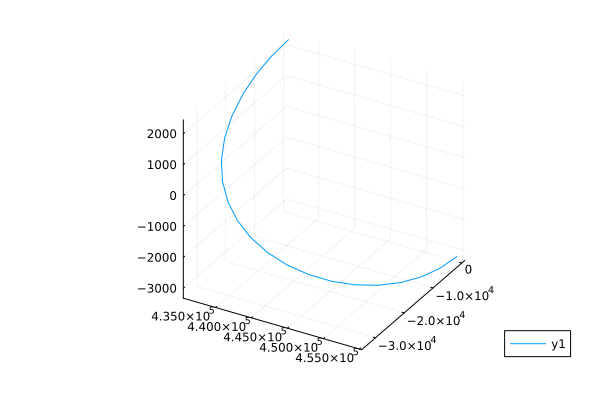

In [546]:
plot(xtraj_halfperiod_test[1,:],xtraj_halfperiod_test[2,:], xtraj_halfperiod_test[3,:])

In [557]:
test_deltas = xtraj_halfperiod_test - reference_trajectory[:,21:end]

6×21 Matrix{Float64}:
  0.00632751  -0.00239001    0.000566301  …  -0.065728     -0.0858928
 -1.06855e-5   0.00103647    0.000229083      0.0796148     0.0944971
 -0.00020897   0.00016469    3.11072e-5      -0.000764166  -0.00218679
  2.23855e-7  -0.0109318    -0.00415312      -0.0416514    -0.0585258
 -1.23293e-7   0.00312187    0.000852125      0.0368048     0.0400565
 -1.28285e-8   0.000497566   0.000124634  …  -0.00249169   -0.00358718

In [560]:
test_deltas - solution_xm[:,1:21]

6×21 Matrix{Float64}:
 0.0  -0.00677219   -0.00157207   -0.00653527   …  -0.0630078    -0.0906146
 0.0   0.00118438    0.000229083   0.00326414       0.0810497     0.09513
 0.0   0.000285821   3.11072e-5    0.000276667     -0.000856976  -0.00197709
 0.0  -0.000403638  -0.00185107   -0.00116508      -0.0431826    -0.0585258
 0.0   0.00356642    0.000852125   0.00366579       0.0368048     0.0400565
 0.0   2.38792e-5    0.00010292    9.68727e-5   …  -0.00249169   -0.00358718

In [561]:
#linear problem is good
solution_xm[:, 1:21]

6×21 Matrix{Float64}:
  0.00632751   0.00438218    0.00213837   …  -0.00272014    0.00472176
 -1.06855e-5  -0.000147906   7.38047e-17     -0.00143483   -0.00063291
 -0.00020897  -0.000121131   1.024e-16        9.28093e-5   -0.0002097
  2.23855e-7  -0.0105282    -0.00230205       0.00153129    1.68028e-17
 -1.23293e-7  -0.000444542  -4.20056e-16     -1.92886e-16  -4.55776e-17
 -1.28285e-8   0.000473687   2.17143e-5   …   1.33652e-16   7.56188e-17

In [ ]:
#linear problem is good and solves
test = zeros(21)

for k=1:21
    test[k] = dot(test_deltas[:,k], unstable_directions_2_2[:,k])

end


In [ ]:
test

In [ ]:
plot(test .>0)

In [ ]:
plot(test.>0)

In [ ]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

In [ ]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [ ]:
1e-3*L

In [ ]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

In [ ]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [ ]:
all_optimal_x

In [ ]:
all_optimal_x_formatted

In [ ]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

In [ ]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [ ]:
all_optimal_u

In [ ]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

In [ ]:
all_utraj

In [ ]:
plot(all_utraj[1,1:200])

In [ ]:
plot(all_utraj[2,1:200])

In [ ]:
plot(all_utraj[3,1:200])

In [ ]:
#this is for 5 orbits
#plot(all_utraj[1,1:200])

In [ ]:
# plot(all_utraj[2,1:400])

In [ ]:
# plot(all_utraj[3,1:400])

In [ ]:
# size(all_utraj)

In [ ]:
one_orbit = all_utraj[:,1:40]

In [ ]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [ ]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

In [ ]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [ ]:
all_xtraj

In [ ]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [ ]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [ ]:
#plot the final orbit
size(all_xtraj)

In [ ]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [ ]:
#plot(optimal_u[1,:].*acceleration_scale)

In [ ]:
#plot(optimal_u[2,:])

In [ ]:
#plot(optimal_u[3,:])

In [ ]:
acceleration_scale

In [ ]:
scaled_control = all_utraj./acceleration_scale

In [ ]:
#integrate over the timestep to get the velocity cost in km/s
x_cost = sum(abs.(scaled_control[1,:]))*(Δt*time_scale)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt*time_scale)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt*time_scale)

In [ ]:
#velocity cost in m/s
x_cost_ms = x_cost*1e3
y_cost_ms = y_cost*1e3
z_cost_ms = z_cost*1e3

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

In [ ]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

In [ ]:
cost_per_rev = all_cost/orbit_num

In [ ]:
#Exclude the first 10 timesteps to fix the injection error
x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt*time_scale) *1e3
y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt*time_scale) *1e3
z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt*time_scale) *1e3

display(x_cost_good)
display(y_cost_good)
display(z_cost_good)

In [ ]:
#cost for 95 revs
all_cost_good = x_cost_good + y_cost_good + z_cost_good

In [ ]:
#final_mpc = reference_trajectory + optimal_x

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [ ]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [ ]:
#diff = final_mpc - reference_trajectory

In [ ]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

In [ ]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [ ]:
all_xtraj[:,end]

In [ ]:
all_optimal_x[:,:,end]

In [ ]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

In [ ]:
all_optimal_x

In [ ]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

In [ ]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [ ]:
delta_end = end_state - reference_trajectory[:,end]

In [ ]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [ ]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [ ]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [ ]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

In [ ]:
plot(deltaaa[6,:])

In [ ]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

In [ ]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end


In [ ]:
constraint_check_test

In [ ]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [ ]:
constraint_check

In [ ]:
plot(constraint_check[1:21].>0)

In [ ]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

In [ ]:
dot(delta_end, unstable_directions[:,end])

In [ ]:
#check this constraint 
#works with pi/5 too 

c_test = unstable_directions[:,end]/tan(pi/6)
#c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

manifold_constraint_test
#push!(cons, manifold_constraint <= 0)

In [ ]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

In [ ]:
#escapes on the right for positive unstable direction!
plot(end_state_traj[1,:], end_state_traj[2,:])

scatter!([end_state_traj[1,1]], [end_state_traj[2,1]])

In [ ]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [ ]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [ ]:
reference_trajectory

In [ ]:
nocontrol = forward_rollout + reference_trajectory

In [ ]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])